# Industry classification with sentence vec

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.preprocessing import LabelEncoder
from combine_models import *
from clustering_class import *
from combine_models import *
from utils import *

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("max_colwidth", 100)
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False
sns.set(font="SimHei")
%load_ext autoreload
%autoreload 2

In [3]:
cleaned_dat = pd.read_csv("data/clean_desc_data.csv")
short = cleaned_dat[cleaned_dat["intro"].str.len() <= 512]
big = cleaned_dat[cleaned_dat["intro"].str.len() > 512]
short_intro = short["intro"].values.tolist()
big_first = pd.concat([big["ticker"], big["intro"].str[:512]], axis=1)
big_second = pd.concat([big["ticker"], big["intro"].str[512:1024]], axis=1)
big_second = big_second[big_second.iloc[:, 1].str.len() > 100]
short_intro = short["intro"].values.tolist()
big_first_intro = big_first["intro"].values.tolist()
big_second_intro = big_second["intro"].values.tolist()

## bag of words matrix

In [4]:
f = open("data/baidu_stopwords.txt", "r")
stopwords = f.read().splitlines()
f.close()
companylist = cleaned_dat["ticker"]
disc = cleaned_dat["intro"]
bag_of_words = bag_of_words(companylist, disc)
bag_of_words.transform(stopwords=stopwords)
bag_matrix = bag_of_words.get_vector()

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.553 seconds.
Prefix dict has been built succesfully.
/home/kindhjj/.conda/envs/hejj3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ain', 'aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'll', 'mon', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [5]:
print('shape of bag of words matrix is: ',bag_matrix.shape)
bag_matrix.rename(columns={'ticker':'company'},inplace=True)
bag_matrix.iloc[:5,:200]

shape of bag of words matrix is:  (3924, 35773)


,company,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198
0,603363.SH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,603128.SH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,688039.SH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,603127.SH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,601068.SH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

## BERT matrix

```there are 6 layer's outputs from bert, we need to choose a good output layer```

In [6]:
big_bert1 = pd.read_csv("bert_vec_output/first_long_CLS_long_bert.csv").iloc[:, 1:]
big_bert2 = pd.read_csv("bert_vec_output/second_long_CLS_long_bert.csv").iloc[:, 1:]
short_bert = pd.read_csv("bert_vec_output/short_CLS_long_bert.csv").iloc[:, 1:]
all_data = []
filte = []
for i in big_first["ticker"]:
    filte.append(True) if i in big_second["ticker"].values else filte.append(False)
for i in range(6):
    big_bert1_i = big_bert1.iloc[:, i * 1024 : (i + 1) * 1024].copy()
    big_bert2_i = big_bert2.iloc[:, i * 1024 : (i + 1) * 1024].copy()
    short_bert_i = short_bert.iloc[:, i * 1024 : (i + 1) * 1024].copy()
    big_bert2_i.index = big_bert1_i[filte].index
    big_bert1_i[filte] = (big_bert1_i[filte] + big_bert2_i) / 2
    big.index = big_bert1_i.index
    short.index = short_bert_i.index
    big_bert1_i.insert(loc=0, column="company", value=big["ticker"])
    short_bert_i.insert(loc=0, column="company", value=short["ticker"])
    all_data.append(pd.concat([short_bert_i, big_bert1_i], axis=0, ignore_index=True))

In [7]:
namelist = all_data[0]["company"].values.tolist()
vec = all_data[0].iloc[:, 1:].values
print('bert matrix shape is: ',vec.shape)

bert matrix shape is:  (3924, 1024)


## Use the method from paper

In [8]:
paper_df=pd.read_csv('paper.csv').iloc[:,1:]
paper_df.head()

,company,paper_class
0,000786.SZ,0
1,600815.SH,0
2,600298.SH,0
3,002191.SZ,0
4,600120.SH,0


## Use official classification

In [9]:
official_df=pd.read_csv('data/official_class.csv',index_col=0)
le=LabelEncoder()
le_class=le.fit_transform(official_df['official_class'])
chinese_class=official_df['official_class']
official_df['official_class']=le_class
print('there are %d industries in official classification'%len(set(chinese_class)))
print('there are %d companys in official classification'%len(chinese_class))
official_df.head()

there are 24 industries in official classification
there are 3802 companys in official classification


,company,official_class
0,000001.SZ,21
1,000002.SZ,11
2,000004.SZ,17
3,000005.SZ,18
4,000006.SZ,11


## Use machine learning cluster 

In [10]:
kmean_class = ML_cluster(vec, namelist)
gmm_class = ML_cluster(vec, namelist)
kmean_class.generate_clusters("kmean", "org", n_clusters=24)
gmm_class.generate_clusters("gmm", "org", n_clusters=24)
kmean_df=kmean_class.output_clusters_df()
gmm_df=gmm_class.output_clusters_df()
kmean_df.head()

,company,kmean_class
0,603363.SH,17
1,603127.SH,9
2,601068.SH,7
3,603551.SH,5
4,603298.SH,6


## Identify classification effects

In [11]:
combine=combine_models()
bert_matrix=all_data[0].copy()
matrix_list=combine.get_merged_matrix([bert_matrix,bag_matrix],[official_df,paper_df, kmean_df, gmm_df])
#combine.get_combine_cluster([official_df,paper_df, kmean_df, gmm_df])
combine_class = combine.combine_cluster
#matrix_list=combine.get_merged_matrix([bert_matrix,bag_matrix],[official_df,paper_df, kmean_df, gmm_df])
combine_class.head()

,company,official_class,paper_class,kmean_class,gmm_class
0,000001.SZ,21,21,14,13
1,000002.SZ,11,10,16,9
2,000004.SZ,17,20,9,3
3,000005.SZ,18,10,16,9
4,000006.SZ,11,10,16,9


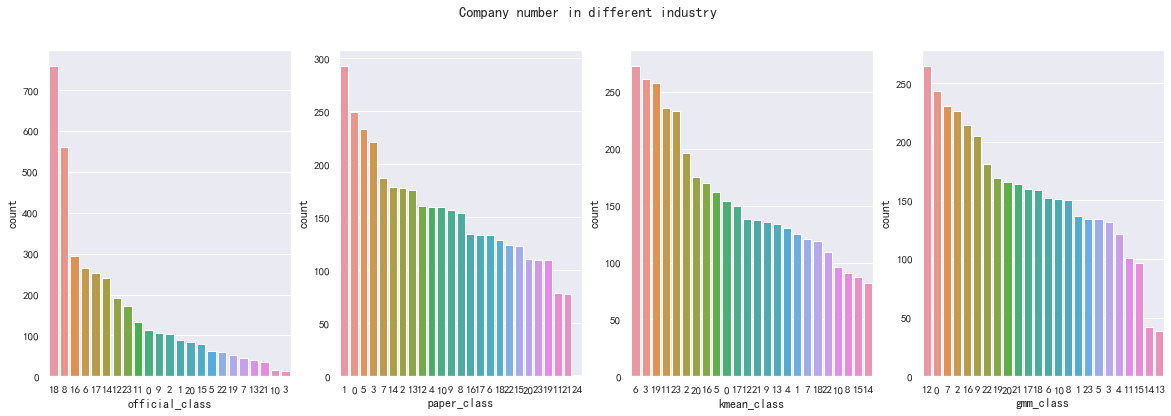

In [12]:
first_analysis=performance_analysis('matrix_performance',class_df=combine_class,embadding_list=matrix_list)
first_analysis.plot_count_plot()

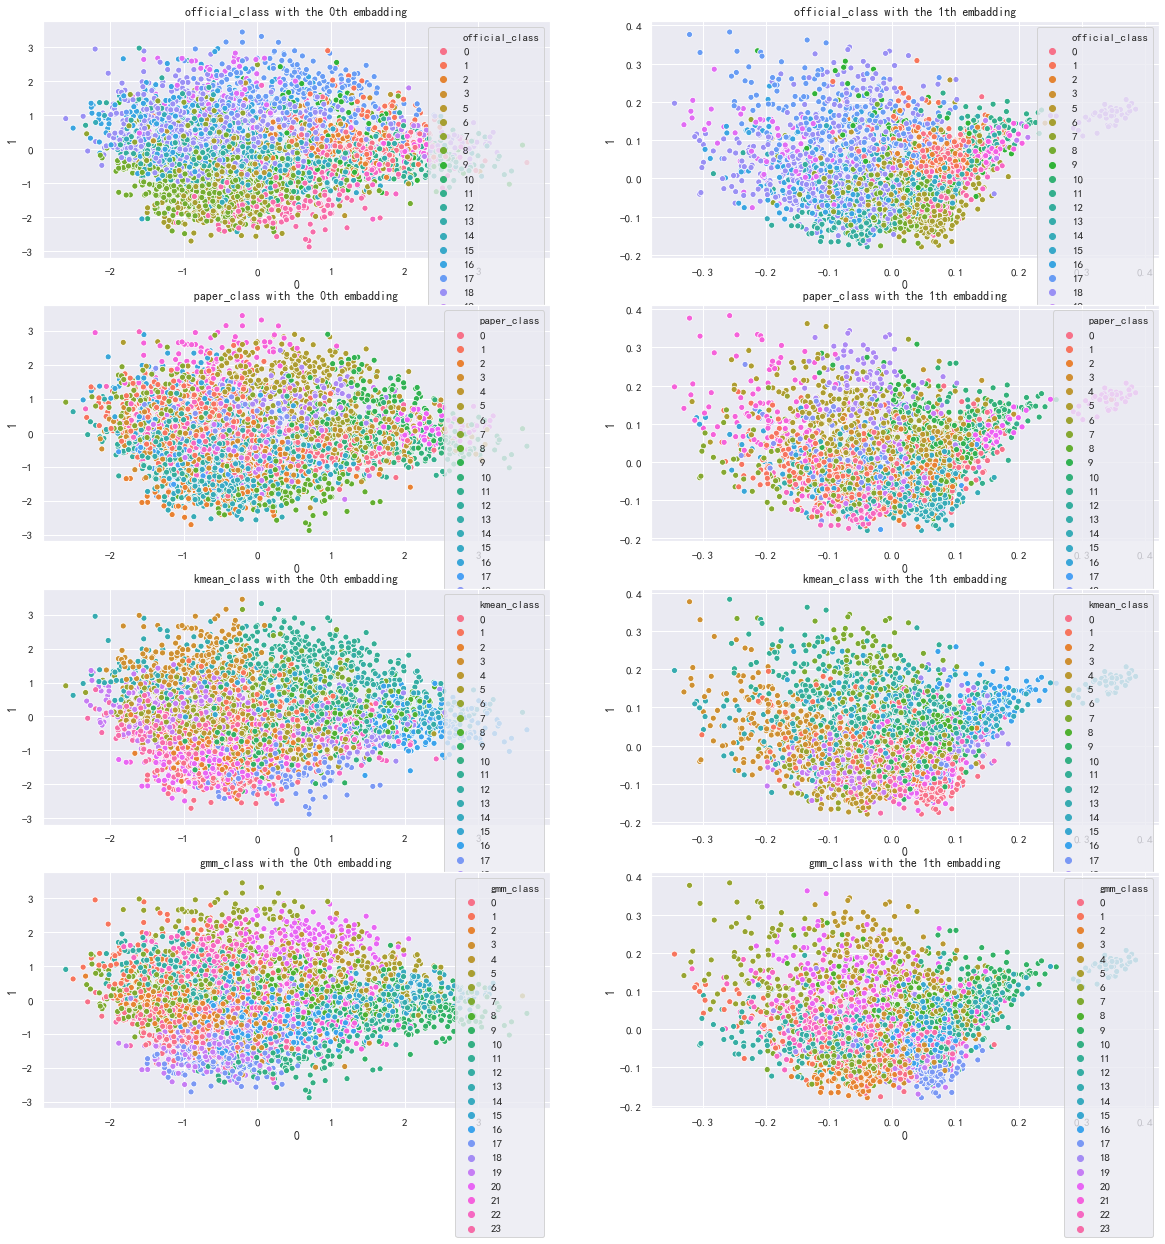

In [13]:
first_analysis.plot_reducted_classification()

## Test individual return with class return

In [14]:
price = pd.read_csv("data/full stock price 20190630-20191231.csv", index_col=0)
price["date"] = pd.to_datetime(price["date"], format="%Y-%m-%d")
price = trans_ticker(price)
price.sort_values(by=['symbol','date'],inplace=True)
stock_return=price.groupby(by=['symbol'])['adjusted'].pct_change()
price['adjusted']=stock_return
price.dropna(inplace=True)
price.set_index(pd.Index(range(len(price))),inplace=True)
price.rename(columns={'symbol':'company','adjusted':'return'},inplace=True)
price.head()

,company,date,return
0,000001.SZ,2019-07-02,0.017947
1,000001.SZ,2019-07-03,-0.011989
2,000001.SZ,2019-07-04,-0.001428
3,000001.SZ,2019-07-05,-0.005004
4,000001.SZ,2019-07-08,-0.023707


In [16]:
second_analysis=performance_analysis(mode='return_performance',class_df=combine_class,return_df=price)
second_analysis.get_daliy_return()
second_analysis.get_statistical_discribe()
second_analysis.get_wellness()

/home/kindhjj/.conda/envs/hejj3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/kindhjj/.conda/envs/hejj3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/kindhjj/.conda/envs/hejj3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/kindhjj/.conda/envs/hejj3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


Mean of R square of official_class classification is:  0.3756176701565067
Mean of R square of paper_class classification is:  0.35122881021953267
Mean of R square of kmean_class classification is:  0.3332650337302723
Mean of R square of gmm_class classification is:  0.34522969419499355


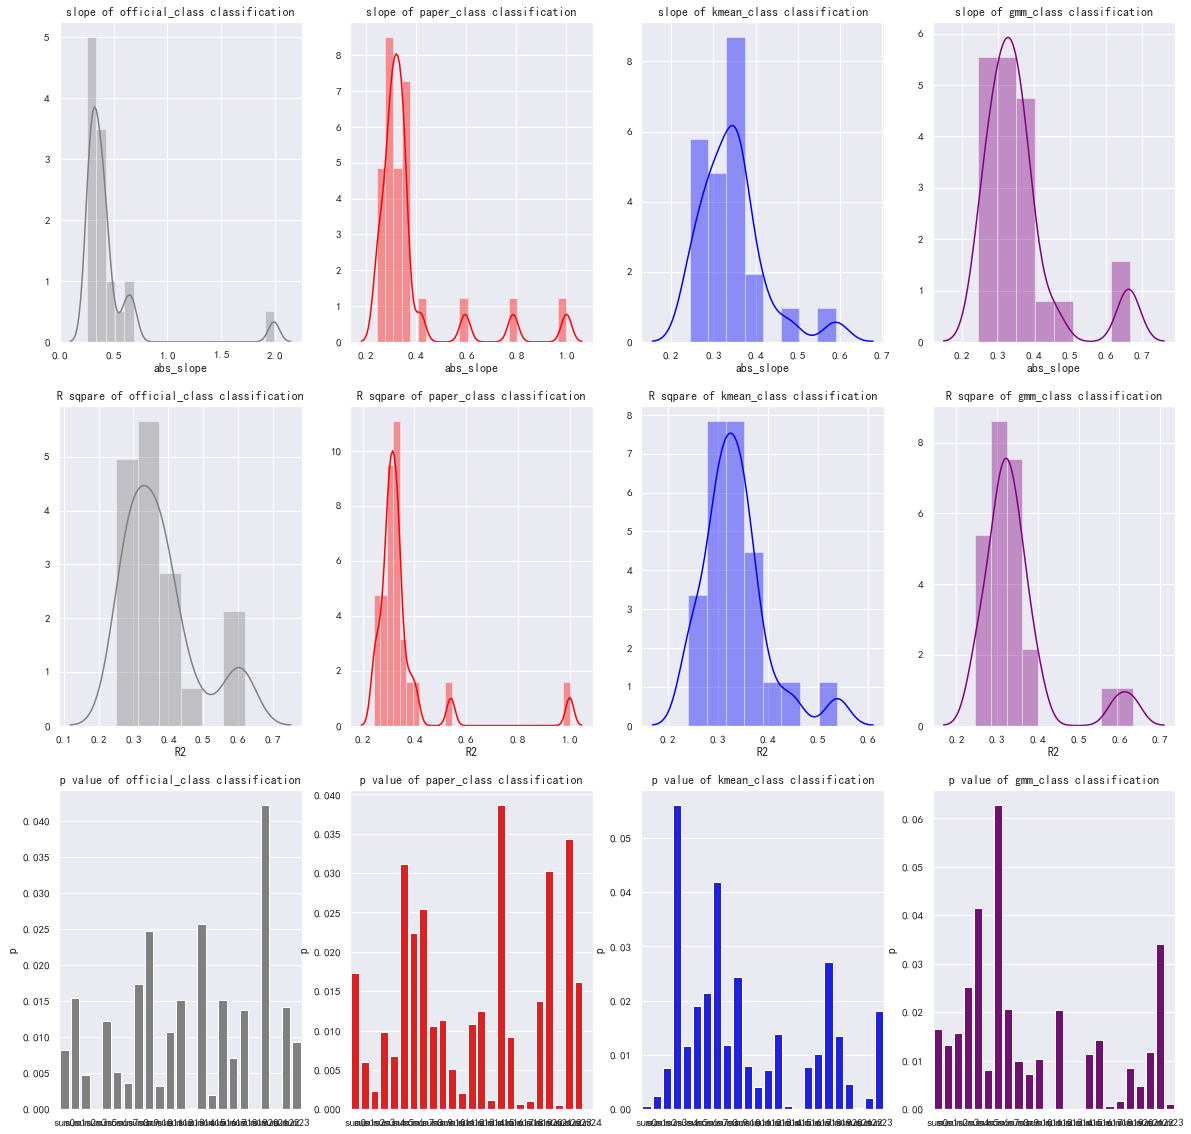

In [18]:
second_analysis.get_regression_plot()

## Select the best model

In [17]:
name_list=bag_matrix['company'].sort_values()
combine=combine_models()
combine_embadding=combine.get_combine_embadding(name_list,[i for i in all_data])

In [27]:
name_list=bag_matrix['company'].sort_values()
combine=combine_models()
combine_embadding=combine.get_combine_embadding(name_list,[bag_matrix])

In [28]:
cluster=get_all_cluster(name_list,combine_embadding)

In [ ]:
all_cluster_bert=cluster.get_all_cluster(n_cluster=24,random_state=100)

In [22]:
all_cluster_bert.to_csv("all_cluster_bert.csv")

In [23]:
bag_matrix.shape

(3924, 35773)

In [31]:
cluster=pd.read_csv('all_cluster_bert.csv',index_col=0)
cluster.reset_index(drop=True,inplace=True)
performance=performance_analysis(mode='return_performance',class_df=cluster,return_df=price)
performance.get_wellness()
performance.R2

/home/kindhjj/.conda/envs/hejj3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/kindhjj/.conda/envs/hejj3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/kindhjj/.conda/envs/hejj3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/kindhjj/.conda/envs/hejj3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


[('1th embadding with org kmean', 0.28728598766038554),
 ('1th embadding with org gmm', 0.28677529484658015),
 ('1th embadding with cor kmean', 0.3019623805843014),
 ('1th embadding with cor gmm', 0.292636649117187),
 ('1th embadding with cos kmean', 0.30775757050952995),
 ('1th embadding with cos gmm', 0.3040995496936079),
 ('2th embadding with org kmean', 0.2858854127011701),
 ('2th embadding with org gmm', 0.2846554631852459),
 ('2th embadding with cor kmean', 0.29673272337444395),
 ('2th embadding with cor gmm', 0.29713888485036893),
 ('2th embadding with cos kmean', 0.2965375247999873),
 ('2th embadding with cos gmm', 0.2998323181280789),
 ('3th embadding with org kmean', 0.28611994571107313),
 ('3th embadding with org gmm', 0.28732111607848965),
 ('3th embadding with cor kmean', 0.3019692854343792),
 ('3th embadding with cor gmm', 0.3115502586434072),
 ('3th embadding with cos kmean', 0.29695254161615775),
 ('3th embadding with cos gmm', 0.2987658697465006),
 ('4th embadding with

In [42]:
import pprint
with open('R2.txt','w') as f:
    f.write(pprint.pformat(performance.R2))
    f.close